# Looks at the number density of objects on the DC2 footprint dr6

- Extract number counts from dr6 data with the gold sample and some basic cuts;

- Split into bins of magnitude, and measure number count fluctuations with maf maps

- Split into photo-z bins; Try to do a sanity check cf. Zilong's figures


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

#import rubin_sim.maf as maf

import healpy as hp

import os

In [2]:
#dump save
import pickle
#save this
def dump_save(stuff,filename):
    '''This saves the dictionary and loads it from appropriate files'''
    with open(filename,'wb') as fout:
        pickle.dump(stuff,fout,pickle.HIGHEST_PROTOCOL)
        #json.dump(self.impute, fout, sort_keys=True, indent=3)
    #print('written impute ditionary:',filename)
    return 0
def dump_load(filename):
    with open(filename,'rb') as fin:
        stuff=pickle.load(fin)
        #self.impute = json.load(fin)
    #print('loaded impute ditionary:',filename)
    return stuff

In [5]:
#use dr6 data

In [3]:
#This function loops over the tracts, extracting gal from certain pixels, and bin the properties (e.g. delta magnitude, delta z)
tract_info=np.loadtxt('/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/tract_info.txt')

def scan_over_tracts(nside):
    """
    required pixels: nside=128
    bins: dictionary with matching keys to props, containing bin edges for the histogram
    """
    
    galmap=np.zeros(int(12*nside**2))
        
    tot=0
    for ii, tract in enumerate(tract_info[:,0]):
        
        if tot%50==0:
            print('Done %s tracts.'%tot)
        
        catdir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/DC2_obj_with_pz-tract-%s.fits'%int(tract)
        
        #check if directory exist:
        if os.path.isfile(catdir) == True:
            
            fin=fits.open(catdir)
            
            sel=select_objects(fin)
            
            if len(sel)>0:
            
                ra=fin[1].data['ra'][sel]
                dec=fin[1].data['dec'][sel]
                #check if inside the pixels input
                cat_pix=hp.ang2pix(nside, ra, dec, lonlat=True)

                cc=np.histogram(cat_pix, bins=np.arange(int(12*nside**2)+1))

                galmap+=cc[0]

            tot+=1
    
    return galmap

In [4]:
#load mask
savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname = savedir+'obj_footprint_mask-nside-128.fits'
mask = hp.read_map(fname)

In [5]:
def binned_corr(densmap, sysmap, mask, ranges):
    
    #densmap
    Ndens = len(densmap.keys())
    Nbins = 9
    
    binedge=np.linspace(ranges[0], ranges[1], Nbins+1)
    bincen = ((binedge+np.roll(binedge,1))*0.5)[1:]

    bin_index = np.digitize(sysmap[mask.astype(bool)],binedge)

    #print(np.unique(bin_index))
    galnorm_z_stats=np.zeros((Nbins,2,Ndens))

    for jj in range(Ndens):
        for ii in range(Nbins):
            ind = np.where(bin_index==(ii+1))[0]
            #use this to compute the scatter around mean in the gal pixels
            galnorm_z_stats[ii,0,jj]=np.mean(densmap[jj][mask.astype(bool)][ind])
            npix = len(ind)
            galnorm_z_stats[ii,1,jj]=np.std(densmap[jj][mask.astype(bool)][ind])/np.sqrt(npix)

    return bincen, galnorm_z_stats

# 1. Trend with various systematic maps

In [5]:
#choose maf maps to load:
metric_name_list = [
    'Median_airmass', #'Median_normairmass', 
    'Median_dist2Moon', 'Median_fiveSigmaDepth',
    'Median_filtSkyBrightness', 'Median_FWHMeff', 
    'CoaddM5'#, 'ExgalM5', 'ExgalM5_with_cuts'
]

MAFMAP={}

Opsimdir = '/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/'
for jj in range(len(metric_name_list)):
    MAF=metric_name_list[jj]
    
    band='i'
    tag='_%s_%s_and_nightlt1825_HEAL.fits'%(MAF, band)
    title='%s-band %s'%(band, MAF)

    fname=Opsimdir+'minion_1016_dc2'+tag
    MAFMAP[MAF]=hp.read_map(fname)

In [6]:
imag_bins=[20, 22, 24, 25, 25.3]

In [30]:
#now extract the density map for different i-band magnitude counts

galmap_imag={}

for kk in range(len(imag_bins)):
    
    if kk<(len(imag_bins)-1):
        bin1=imag_bins[kk]
        bin2=imag_bins[kk+1]
        print(bin1, bin2)

        def select_objects(fin):
            #a function used to further select objects based on e.g., limiting magnitude
            mag=fin[1].data['mag_i_cModel']
            sel = np.where((mag>=bin1)&(mag<bin2))[0]
            return sel
        
    if kk==(len(imag_bins)-1):
        
        print('<25.3')
        
        def select_objects(fin):
            #a function used to further select objects based on e.g., limiting magnitude
            #no selection
            mag=fin[1].data['mag_i_cModel']
            sel = np.arange(len(mag))
            return sel

    nside=128
    galmap_imag[kk]=scan_over_tracts(nside)


20 22
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
22 24
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
24 25
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
25 25.3
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.


In [31]:
#save data

#save these data
savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname=savedir+'obj_counts-imagbins-nside-128.pkl'
out={'zbin': imag_bins, 'data': galmap_imag}
dump_save(out, fname)

0

53589623.0


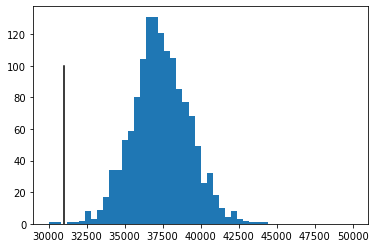

In [55]:
#mask for dr6
savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname=savedir+'obj_counts-imagbins-nside-128.pkl'
out = dump_load(fname)
galmap_imag = out['data']
print(sum(galmap_imag[4]))

#print(galmap_imag[4].max())

#generate dr6 mask
mask0=np.zeros(len(galmap_imag[4]))
mask0[galmap_imag[4]>0]=1

#look at the distribution of galaxy counts:
cc=plt.hist(galmap_imag[4][mask0.astype(bool)],bins=50, range=[30000,50000])

#determine cut
cut=31000
plt.plot([cut,cut],[0,100],'k')
mask_conserve = np.zeros(len(galmap_imag[4]))
mask_conserve[galmap_imag[4]>31000]=1

In [58]:
#save the conservative map
savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname = savedir+'obj_footprint_mask-nside-128.fits'
hp.write_map(fname, mask_conserve)

setting the output map dtype to [dtype('float64')]


Plot variation of galaxy number as a function of different systematics

In [20]:
#load the galaxy maps:

savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname=savedir+'obj_counts-imagbins-nside-128.pkl'
out = dump_load(fname)
imag_bins = out['zbin']
galmap_imag = out['data']


In [21]:
densmap = {}

for key in galmap_imag.keys():
    densmap[key] = galmap_imag[key]/np.mean(galmap_imag[key][mask.astype(bool)])*mask

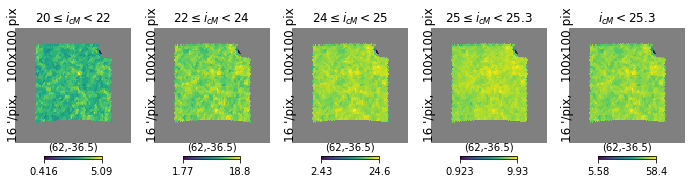

In [51]:
#show galaxy number counts at different magnitude intervals, conver this into the counts per arcmin^2
fig,axarr=plt.subplots(1,len(imag_bins),figsize=[12,3])

pixarea = (hp.nside2resol(128, arcmin = True))**2

maxmin_list=[
    [2.44,4.96],
    [11.1,18.1],
    [10.4,21.8],
    [1.65,6.28],
    [27.0,49.9]
]

title=[
    '$20 \\leq i_{cM} < 22$',
    '$22 \\leq i_{cM} < 24$',
    '$24 \\leq i_{cM} < 25$',
    '$25 \\leq i_{cM} < 25.3$',
    '$i_{cM} < 25.3$',
]

for ii in range(len(imag_bins)):
    plt.sca(axarr[ii])
    show = (np.copy(galmap_imag[ii])/pixarea)*mask
    show[~mask.astype(bool)]=hp.UNSEEN
    hp.gnomview(show, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, hold=True,
               title=title[ii])#,min=maxmin_list[ii][0], max=maxmin_list[ii][1])

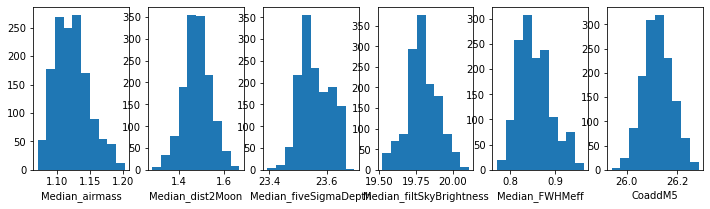

In [52]:
#plot distribution of observables
fig,axarr=plt.subplots(1,6,figsize=[12,3])

for ii, key in enumerate(MAFMAP.keys()):
    plt.sca(axarr[ii])
    cc=plt.hist(MAFMAP[key][mask.astype(bool)],bins=10)
    plt.xlabel(key)


In [44]:
#for each of the systematic map, compute this:

galnum_sys_corr={}
ranges_list=[
    [1.1, 1.19],
    [1.4, 1.6],
    [23.5,23.63],
    [19.6,19.9],
    [0.82,0.93],
    [26.05,26.21]
]

for jj in range(len(metric_name_list)):
    MAF=metric_name_list[jj]

    sysmap = MAFMAP[MAF]

    ranges = ranges_list[jj]
    galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF] = binned_corr(densmap, sysmap, mask, ranges)

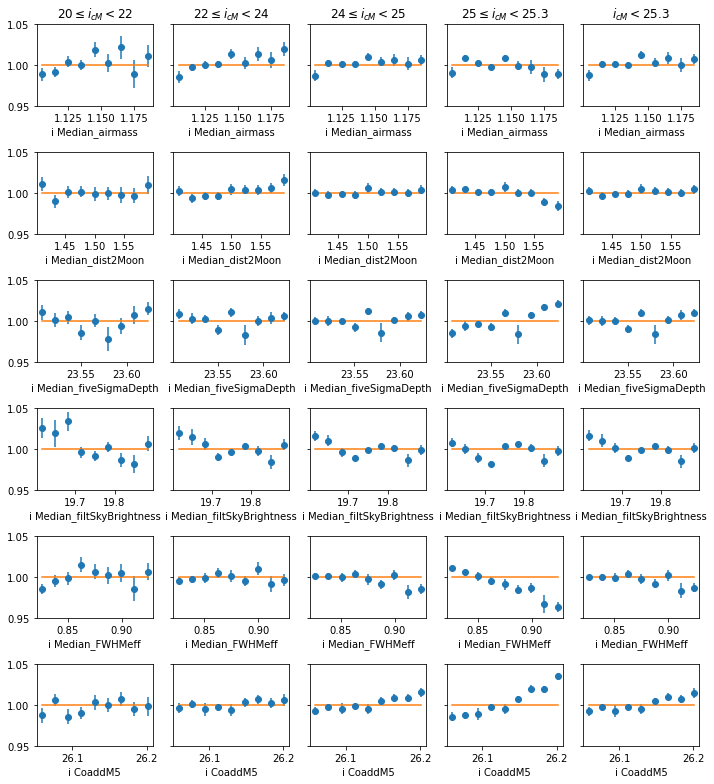

In [49]:
fig,axarr=plt.subplots(len(metric_name_list),len(imag_bins),figsize=[10,11], sharey=True)

for ii in range(len(metric_name_list)):
    MAF=metric_name_list[ii]
    for jj in range(len(imag_bins)):
        plt.sca(axarr[ii,jj])
        plt.errorbar(galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF][:,0,jj], yerr=galnum_sys_corr[MAF][:,1,jj],fmt='o')
        plt.ylim([0.95,1.05])
        plt.plot(galnum_sys_corr[MAF+'-bincen'], np.ones(len(galnum_sys_corr[MAF+'-bincen'])))
        if ii==0:
            plt.title(title[jj])
        plt.xlabel('i '+MAF)
plt.tight_layout()

Add a few more maps: nexp_sum, ebv, stellar

In [8]:
add_sysmaps={}

prop = 'nexp_sum'
supmapdir='/global/cscratch1/sd/qhang/minion_1016/MAF-5year/supreme_map/'
band='i'
fname = supmapdir + 'supreme_dc2_dr6d_v3_%s_%s-nside-128.fits'%(band, prop)
title = '%s-band %s'%(band, prop)
add_sysmaps[title] = (hp.read_map(fname))*mask
    
othermapdir = '/global/cscratch1/sd/qhang/other_systematic_maps/'
fname = othermapdir + 'ebv_ring_rot_512.fits'
mapin = hp.read_map(fname)
mapin = hp.ud_grade(mapin, 128)
add_sysmaps['ebv'] = mapin*mask
    
print(add_sysmaps.keys())

dict_keys(['i-band nexp_sum', 'ebv'])


In [23]:
#for each of the systematic map, compute this:

galnum_sys_corr={}
ranges_list=[
    [90, 120],
    [0.003, 0.045],
]

for jj, key in enumerate(add_sysmaps.keys()):

    sysmap = add_sysmaps[key]

    ranges = ranges_list[jj]
    galnum_sys_corr[key+'-bincen'], galnum_sys_corr[key] = binned_corr(densmap, sysmap, mask, ranges)

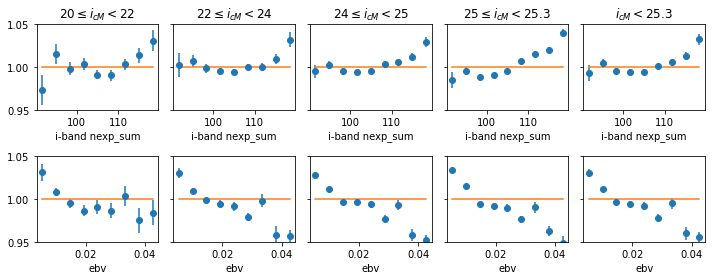

In [26]:
title=[
    '$20 \\leq i_{cM} < 22$',
    '$22 \\leq i_{cM} < 24$',
    '$24 \\leq i_{cM} < 25$',
    '$25 \\leq i_{cM} < 25.3$',
    '$i_{cM} < 25.3$',
]

fig,axarr=plt.subplots(len(add_sysmaps.keys()),len(imag_bins),figsize=[10,4], sharey=True)

for ii,key in enumerate(add_sysmaps.keys()):
    for jj in range(len(imag_bins)):
        plt.sca(axarr[ii,jj])
        plt.errorbar(galnum_sys_corr[key+'-bincen'], galnum_sys_corr[key][:,0,jj], yerr=galnum_sys_corr[key][:,1,jj],fmt='o')
        plt.ylim([0.95,1.05])
        plt.plot(galnum_sys_corr[key+'-bincen'], np.ones(len(galnum_sys_corr[key+'-bincen'])))
        if ii==0:
            plt.title(title[jj])
        plt.xlabel(key)
plt.tight_layout()

# 2. Sanity checks 

In [7]:
photoz_bins=[0,0.3,0.6,0.9,1.2,1.5,2.0] 

In [53]:
galmap_z={}

for kk in range(len(photoz_bins)-1):

    bin1=photoz_bins[kk]
    bin2=photoz_bins[kk+1]
    print(bin1, bin2)
    
    def select_objects(fin):
        #a function used to further select objects based on e.g., limiting magnitude

        #no selection
        #mag_i=fin[1].data['mag_i_cModel']
        #sel=np.arange(len(mag_i))

        #select i-band magnitudes
        #sel = np.where((mag_i>=24)&(mag_i<25.3))

        #sel on photo-z
        photoz=fin[1].data['photoz_mode']
        sel = np.where((photoz>=bin1)&(photoz<bin2))[0]

        return sel
    
    nside=128
    galmap_z[kk]=scan_over_tracts(nside)

0 0.3
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
0.3 0.6
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
0.6 0.9
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
0.9 1.2
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
1.2 1.5
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.
1.5 2.0
Done 0 tracts.
Done 50 tracts.
Done 100 tracts.
Done 150 tracts.


In [ ]:
#change dr2 --> dr6

In [59]:
#save these data
savedir='/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
fname=savedir+'obj_counts-zbins-nside-128.pkl'
out={'zbin': photoz_bins, 'data': galmap_z}
dump_save(out, fname)

0

Extract three low redshift bins to check if the result makes sense

In [54]:
#normalize by mean galaxy number counts
galnorm_z={}
for ii in range(len(galmap_z.keys())):
    galnorm_z[ii]=galmap_z[ii]/np.mean(galmap_z[ii][mask.astype(bool)])
    galnorm_z[ii]=galnorm_z[ii]*mask

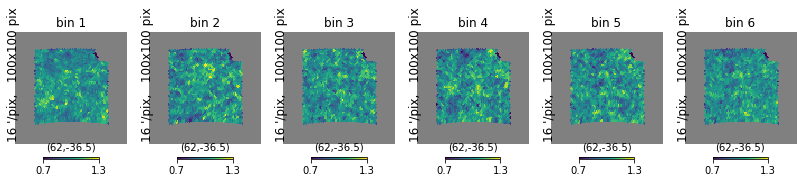

In [55]:
fig,axarr=plt.subplots(1,6,figsize=[14,3])

for ii in range(6):
    plt.sca(axarr[ii])
    show = np.copy(galnorm_z[ii])
    show[~mask.astype(bool)]=hp.UNSEEN
    hp.gnomview(show, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, hold=True,
               title='bin %s'%(ii+1),max=1.3, min=0.7)

In [30]:
#load airmass 
import healsparse as hsp

bb='i'

supmap_dir = '/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/supreme/dr6-wfd/'

fname = supmap_dir+'supreme_dc2_dr6d_v3_%s_airmass_wmean.hs'%bb

testmap = hsp.HealSparseMap.read(fname)

rec_hp = testmap.generate_healpix_map(nside=128,nest=False)
rec_hp[~mask.astype(bool)]=hp.UNSEEN


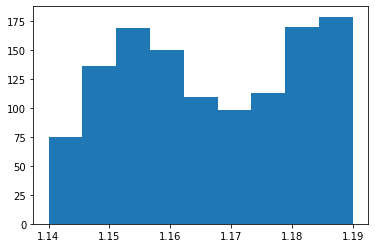

In [35]:
#now measure in bins of airmass:

#bins
airmassbinedge=np.linspace(1.14, 1.19, 10)
cc=plt.hist(rec_hp[mask.astype(bool)],bins=9, range=[1.14,1.19])

ind=np.digitize(rec_hp[mask.astype(bool)], airmassbinedge)

In [56]:
bin_index = np.digitize(rec_hp[mask.astype(bool)],airmassbinedge)

#print(np.unique(bin_index))
galnorm_z_stats=np.zeros((9,2,6))

for jj in range(6):
    for ii in range(9):
        ind = np.where(bin_index==(ii+1))[0]
        #use this to compute the scatter around mean in the gal pixels
        galnorm_z_stats[ii,0,jj]=np.mean(galnorm_z[jj][mask.astype(bool)][ind])
        npix = len(ind)
        galnorm_z_stats[ii,1,jj]=np.std(galnorm_z[jj][mask.astype(bool)][ind])/np.sqrt(npix)

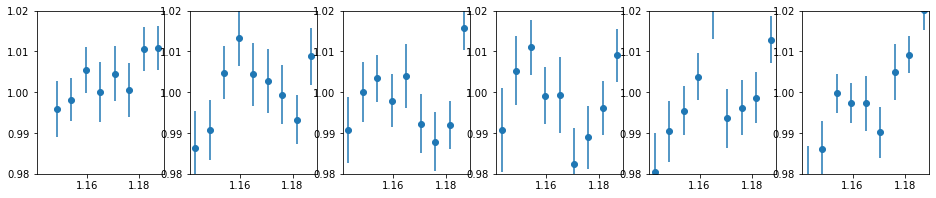

In [58]:
fig,axarr=plt.subplots(1,6,figsize=[16,3])
airmass_x=((airmassbinedge+np.roll(airmassbinedge,1))*0.5)[1:]

for jj in range(6):
    plt.sca(axarr[jj])
    plt.errorbar(airmass_x, galnorm_z_stats[:,0,jj], yerr=galnorm_z_stats[:,1,jj],fmt='o')
    plt.ylim([0.98,1.02])

## Other measures

In [83]:
! ls /global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/*_i_*fits

/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_CoaddM5_i_and_nightlt1825_HEAL.fits
/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_Median_FWHMeff_i_and_nightlt1825_HEAL.fits
/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_Median_airmass_i_and_nightlt1825_HEAL.fits
/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_Median_dist2Moon_i_and_nightlt1825_HEAL.fits
/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_Median_filtSkyBrightness_i_and_nightlt1825_HEAL.fits
/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/minion_1016_dc2_Median_fiveSigmaDepth_i_and_nightlt1825_HEAL.fits


In [101]:
#M5 coadd

OpSim_dir='/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/'

#fname=OpSim_dir+'minion_1016_dc2_Median_airmass_i_and_nightlt1825_HEAL.fits'%bb
fname=OpSim_dir+'minion_1016_dc2_CoaddM5_i_and_nightlt1825_HEAL.fits'

#median sky brightness
#fname=OpSim_dir+'minion_1016_dc2_Median_filtSkyBrightness_i_and_nightlt1825_HEAL.fits'

#median seeing
#fname=OpSim_dir+'minion_1016_dc2_Median_FWHMeff_i_and_nightlt1825_HEAL.fits'

coadd=hp.read_map(fname)

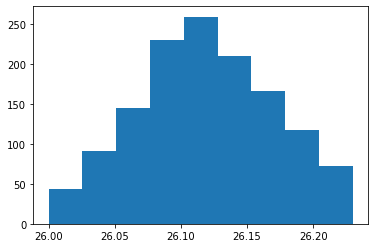

In [103]:
#bins
#airmassbinedge=np.linspace(1.14, 1.19, 10)
cc=plt.hist(coadd[mask.astype(bool)],bins=9,range=[26,26.23])

In [106]:
bin_index = np.digitize(coadd[mask.astype(bool)], cc[1])

#print(np.unique(bin_index))
galnorm_z_stats=np.zeros((9,2,6))

for jj in range(6):
    for ii in range(9):
        ind = np.where(bin_index==(ii+1))[0]
        #use this to compute the scatter around mean in the gal pixels
        galnorm_z_stats[ii,0,jj]=np.mean(galnorm_z[jj][mask.astype(bool)][ind])
        npix = len(ind)
        galnorm_z_stats[ii,1,jj]=np.std(galnorm_z[jj][mask.astype(bool)][ind])/np.sqrt(npix)

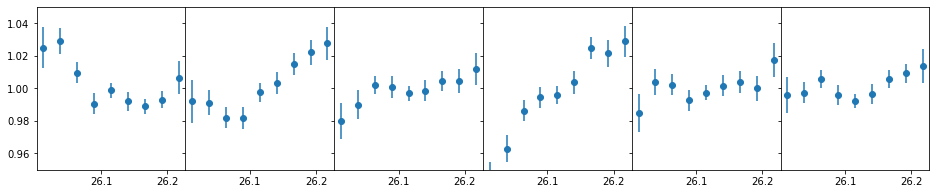

In [111]:
fig,axarr=plt.subplots(1,6,figsize=[16,3],sharey=True)
xx=((cc[1]+np.roll(cc[1],1))*0.5)[1:]

for jj in range(6):
    plt.sca(axarr[jj])
    plt.errorbar(xx, galnorm_z_stats[:,0,jj], yerr=galnorm_z_stats[:,1,jj],fmt='o')
    plt.ylim([0.95,1.05])
    
plt.subplots_adjust(wspace=0)

In [108]:
#if no redshift bins
unbinned_galmap=galmap_z[0]+galmap_z[1]+galmap_z[2]+galmap_z[3]+galmap_z[4]+galmap_z[5]
unbinned_galmap=unbinned_galmap/np.mean(unbinned_galmap[mask.astype(bool)])*mask


In [109]:
galnorm_z_stats_unbinned=np.zeros((9,2))

for ii in range(9):
    ind = np.where(bin_index==(ii+1))[0]
    #use this to compute the scatter around mean in the gal pixels
    galnorm_z_stats_unbinned[ii,0]=np.mean(unbinned_galmap[mask.astype(bool)][ind])
    npix = len(ind)
    galnorm_z_stats_unbinned[ii,1]=np.std(unbinned_galmap[mask.astype(bool)][ind])/np.sqrt(npix)

<ErrorbarContainer object of 3 artists>

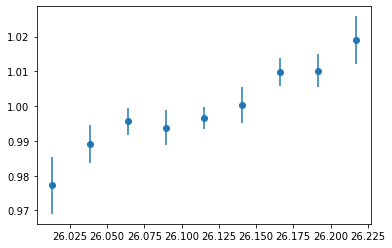

In [110]:
plt.errorbar(xx, galnorm_z_stats_unbinned[:,0], yerr=galnorm_z_stats_unbinned[:,1],fmt='o')
#plt.ylim([0.95,1.05])

# Catalogue for cross-correlation redshift

In [18]:
pzbins = [0, 0.5, 1, 1.5, 2]
outdir = '/global/cscratch1/sd/qhang/DESC_DC2_obs-dr6/'
nside=128

#redshift distribution
z_dist = {}
galmap = {}

for ii in range(len(pzbins)-1):
    print('working on bin %s'%ii)
    fin=fits.open(outdir+'dc2-dr6-catalogue-i_cMdoel-25-25.3-pz-%s-%s.fits'%(pzbins[ii], pzbins[ii+1]))
    #fin[1].header
    ra=fin[1].data['ra']
    dec=fin[1].data['dec']
    z=fin[1].data['redshift_truth']
    print('number of objects: %s'%len(z))
    
    #true z distribution
    cc=np.histogram(z, bins=50, range=[0,3.2])
    z_dist[ii] = cc[0]
    z_dist['bin'] = ((cc[1]+np.roll(cc[1],1))/2.)[1:]
    
    #galmap
    cat_pix=hp.ang2pix(nside, ra, dec, lonlat=True)
    cc=np.histogram(cat_pix, bins=np.arange(int(12*nside**2)+1))
    galmap[ii]=cc[0]

working on bin 0
number of objects: 940272
working on bin 1
number of objects: 4178722
working on bin 2
number of objects: 3087414
working on bin 3
number of objects: 829711


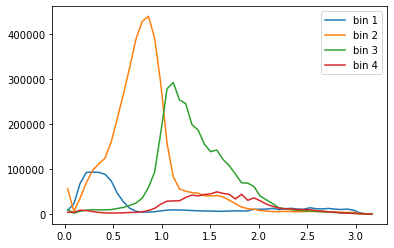

In [22]:
for ii in range(4):
    plt.plot(z_dist['bin'], z_dist[ii], label='bin %d'%(ii+1))
    
plt.legend()

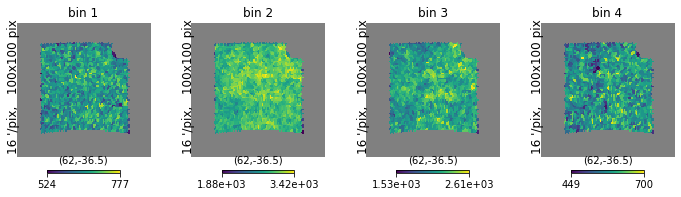

In [60]:
fig,axarr=plt.subplots(1,4,figsize=[12,3])
for ii in range(4):
    plt.sca(axarr[ii])
    show = np.copy(galmap[ii]*mask)
    show[~mask.astype(bool)]=hp.UNSEEN
    hp.gnomview(show, rot=(62, -36.5, 0), xsize=100,ysize=100, reso=16, hold=True,
               title='bin %s'%(ii+1))

In [65]:
#mean number of galaxies within the mask
ii=1
print(np.mean(galmap[ii][mask.astype(bool)]))


2944.0295602018746


In [61]:
densmap = {}

for ii in range(4):
    densmap[ii] = galmap[ii]/np.mean(galmap[ii][mask.astype(bool)])*mask

In [62]:
#for each of the systematic map, compute this:

galnum_sys_corr={}
ranges_list=[
    #[1.1, 1.19],
    #[1.4, 1.6],
    [23.5,23.63],
    #[19.6,19.9],
    [0.82,0.93],
    [26.05,26.21]
]

for jj in range(len(metric_name_list)):
    MAF=metric_name_list[jj]

    sysmap = MAFMAP[MAF]

    ranges = ranges_list[jj]
    galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF] = binned_corr(densmap, sysmap, mask, ranges)

In [29]:
#choose maf maps to load:
metric_name_list = [
    #'Median_airmass', #'Median_normairmass', 
    #'Median_dist2Moon', 
    'Median_fiveSigmaDepth',
    #'Median_filtSkyBrightness', 
    'Median_FWHMeff', 
    'CoaddM5'#, 'ExgalM5', 'ExgalM5_with_cuts'
]

MAFMAP={}

Opsimdir = '/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf/'
for jj in range(len(metric_name_list)):
    MAF=metric_name_list[jj]
    
    band='i'
    tag='_%s_%s_and_nightlt1825_HEAL.fits'%(MAF, band)
    title='%s-band %s'%(band, MAF)

    fname=Opsimdir+'minion_1016_dc2'+tag
    MAFMAP[MAF]=hp.read_map(fname)

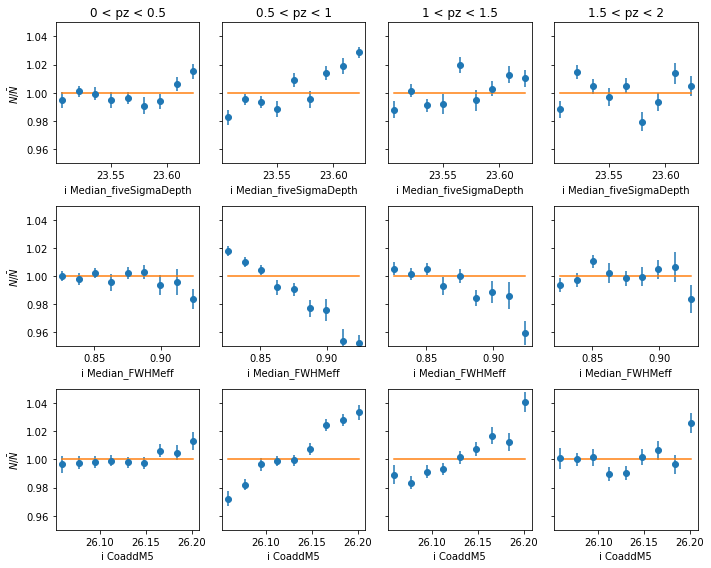

In [63]:
fig,axarr=plt.subplots(len(metric_name_list),len(pzbins)-1,figsize=[10,8], sharey=True)

for ii in range(len(metric_name_list)):
    MAF=metric_name_list[ii]
    for jj in range(len(pzbins)-1):
        plt.sca(axarr[ii,jj])
        plt.errorbar(galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF][:,0,jj], yerr=galnum_sys_corr[MAF][:,1,jj],fmt='o')
        plt.ylim([0.95,1.05])
        plt.plot(galnum_sys_corr[MAF+'-bincen'], np.ones(len(galnum_sys_corr[MAF+'-bincen'])))
        if ii==0:
            plt.title('%s < pz < %s'%(pzbins[jj], pzbins[jj+1]))
        plt.xlabel('i '+MAF)
        if jj==0:
            plt.ylabel('$N/\\bar{N}$')
plt.tight_layout()

In [68]:
#can take the second bin as an example

#fit a polynomial through the N/N_bar vs i_CoaddM5
MAF = 'CoaddM5'
jj=1
coeff = np.polyfit(galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF][:,0,jj], 1, 
                   w=1/galnum_sys_corr[MAF][:,1,jj])

print(coeff)

[ 0.41967755 -9.96147565]


<ErrorbarContainer object of 3 artists>

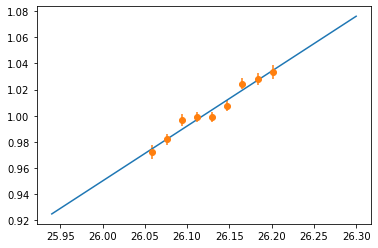

In [72]:
x=np.linspace(25.94, 26.30, 10)
plt.plot(x, x*coeff[0]+coeff[1])
plt.errorbar(galnum_sys_corr[MAF+'-bincen'], galnum_sys_corr[MAF][:,0,jj], yerr=galnum_sys_corr[MAF][:,1,jj],fmt='o')